In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [2]:
files_list = ['Normal.csv', 'AD.csv', 'All.csv', 'EMCI.csv', 'LMCI.csv']

#### ADNI DATA PICS

In [3]:
dir_name = 'scripts/ADNI_pairwise_results/'
df_list = []
for item in [item for item in os.listdir(dir_name) if 'seed' not in item]:
    cur_data = pd.read_csv(dir_name + item, index_col = 0)
    cur_data['data'] = item[:-4]
    df_list += [cur_data]
data = pd.concat(df_list, axis=0)
data.index = range(len(data))
data.dtypes

base_features                  object
classifier                     object
data                           object
eval_accuracy_mean            float64
eval_accuracy_scores           object
eval_accuracy_std             float64
eval_precision_mean           float64
eval_precision_scores          object
eval_precision_std            float64
eval_recall_mean              float64
eval_recall_scores             object
eval_recall_std               float64
eval_roc_auc_mean             float64
eval_roc_auc_scores            object
eval_roc_auc_std              float64
grid_accuracy_best_params      object
grid_accuracy_mean            float64
grid_accuracy_std             float64
grid_precision_best_params     object
grid_precision_mean           float64
grid_precision_std            float64
grid_recall_best_params        object
grid_recall_mean              float64
grid_recall_std               float64
grid_roc_auc_best_params       object
grid_roc_auc_mean             float64
grid_roc_auc

In [4]:
def get_scores(string):

    #string = row.loc[grouped_maxes_ids].eval_accuracy_scores.values[0]
    str_floats = string[2:-1].replace('\n', '').replace('  ', ' ').replace('  ', ' ').replace('  ', ' ').split(' ')
    try:
        scores = [float(item) for item in str_floats if len(item) > 0]
    except:
        print(str_floats)
    return scores

In [5]:
data.norm = data.norm.apply(lambda x: x[:-7])
data.loc[(data.norm == 'binar'), 'norm'] = 'binary'
data.loc[(data.data == 'Normal'), 'data'] = 'Control'
#data.norm.dtype == str
data.base_features = data.base_features.apply(lambda x: x[:-7])

In [6]:
data = data.loc[data.classifier.isin(['grid__LR'])]

In [9]:

forbidden_combinations = [{'norm' : ['-', 'max'], 'base_features' : ['betweenness_centrality']},
                         {'norm' : ['-', 'max'], 'base_features' : ['clustering_coefficient']},
                         {'norm' : ['-', 'max'], 'base_features' : ['eigenvector_centrality']},
                         {'norm' : ['-', 'max'], 'base_features' : ['pagerank']},
                         {'norm' : ['-', 'max'], 'base_features' : ['triangles']}]

all_inds = np.zeros((len(data),))
all_inds = all_inds != 0
'''
for comb in forbidden_combinations:
    comb_keys = sorted(comb.keys())
    inds = np.zeros((len(data),))
    inds = inds == 0
    for key in comb_keys:
        
        loc_inds = data[key].isin(comb[key])
        inds = loc_inds & inds
    all_inds = all_inds | inds    
'''
data = data.iloc[~all_inds]

In [10]:
all_inds.sum()

0

In [11]:
data = data.loc[~all_inds]
def process_centralities(x):
    if 'centrality' in x:
        return x[:-11] + '\n' + 'centrality'
    elif 'clustering' in x:
        return 'clustering' + '\n' + 'coefficient'
    elif x == 'bag_of_edges':
        return 'bag of\n edges'
    else:
        return(x)
data.base_features = data.base_features.apply(process_centralities)

In [13]:
len(data)

181

In [14]:
#data.sort_values(by = 'eval_accuracy_mean', ascending = False)

In [15]:
#np.mean(get_scores(data.loc[[137]].eval_accuracy_scores.values[0]))#

In [16]:
tst = data.sort_values(by = 'eval_recall_mean', ascending = False)

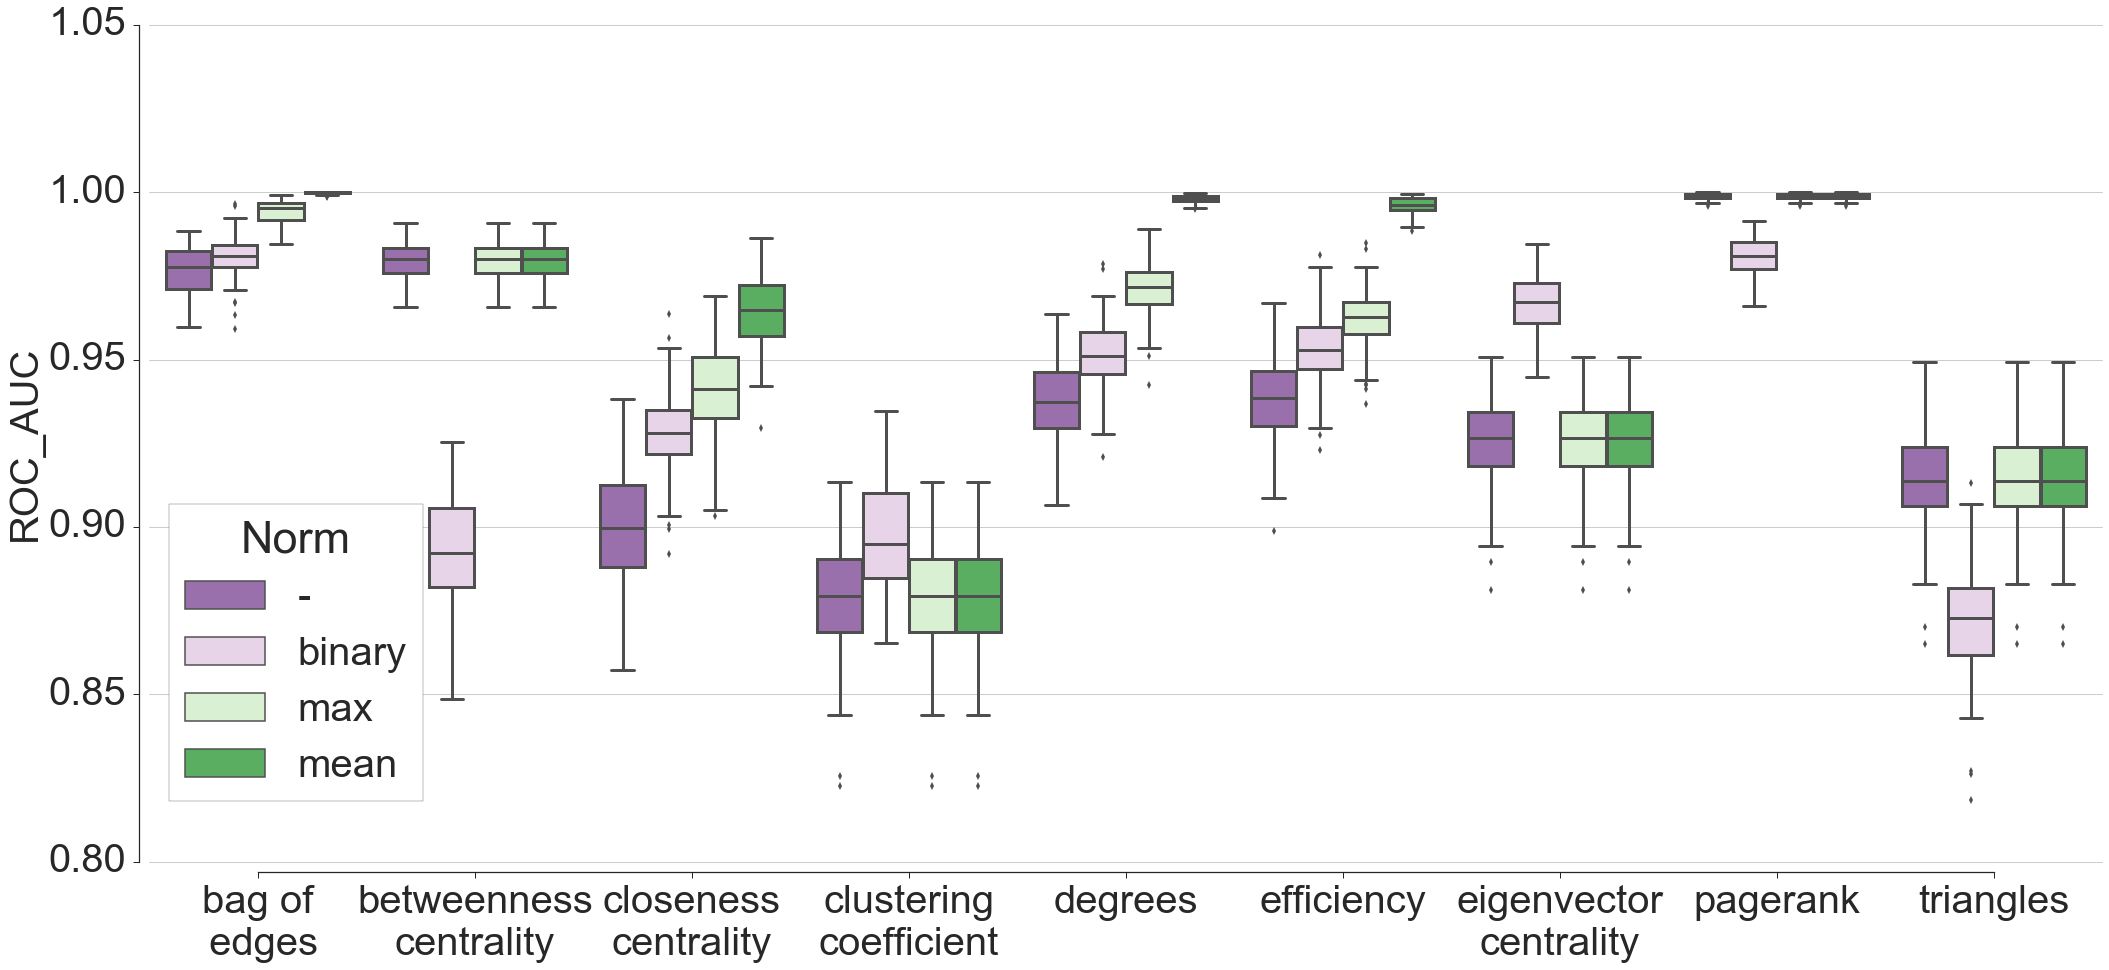

In [17]:
feats = ['data', 'norm', 'base_features', 'eval_accuracy_mean']

target = 'All'
metric = 'roc_auc'
cur_data = tst.sort_values(by = ['data', 'norm', 'base_features', 'eval_' + metric + '_mean'], ascending = False).copy()
cur_data = cur_data.query('data == @target')
grouped_maxes_ids = cur_data.groupby(by = ['data', 'norm', 'base_features'])['eval_' + metric + '_mean'].idxmax().values

cur_data['score_list'] = cur_data.loc[grouped_maxes_ids, 'eval_' + metric + '_scores'].apply(get_scores)

row_vals = []
for i, row in cur_data.loc[grouped_maxes_ids].iterrows():
    prefix = list(row[feats])
    cur_scores = row.score_list
    for i in range(100):
        row_vals += [prefix + [cur_scores[i]]]
to_plot = pd.DataFrame(row_vals, columns = feats + [metric])

sns.set(style="ticks")
plt.figure(figsize = (35,15) )
plot_df = pd.DataFrame(grouped_maxes_ids).reset_index()
# Load the example tips dataset

# Draw a nested boxplot to show bills by day and sex
sns.boxplot(x="base_features", y=metric, hue="norm", data=to_plot, 
            palette="PRGn", saturation = 1.0, width = 0.85, linewidth = 3, 
            order = sorted(to_plot.base_features.unique()))
sns.despine(offset=10, trim=True)
plt.tick_params(axis='both', which='major', labelsize=40)
plt.tick_params(axis='both', which='minor', labelsize=40)
ax = plt.legend(title = 'Norm', fontsize = 40, loc='center left', bbox_to_anchor=(0.0, 0.25), frameon = True)
t = ax.get_title()  #get the text object containing the title
t.set_fontsize(45)  #set the font size
#plt.title('Accuracy for different norms and features for all pairs data', fontsize = 30)
plt.grid(axis = 'y')
plt.xlabel('', fontsize = 40)
plt.ylabel(metric.upper(), fontsize = 40)
#plt.ylim([0.82, 1.00])

plt.savefig('pics/adni_'+ metric +'_boxplots_by_norms_and_feats_without_title.png', transparent=True)

In [51]:
to_plot.max()


data                        All
norm                       mean
base_features         triangles
eval_accuracy_mean     0.993484
roc_auc                       1
dtype: object

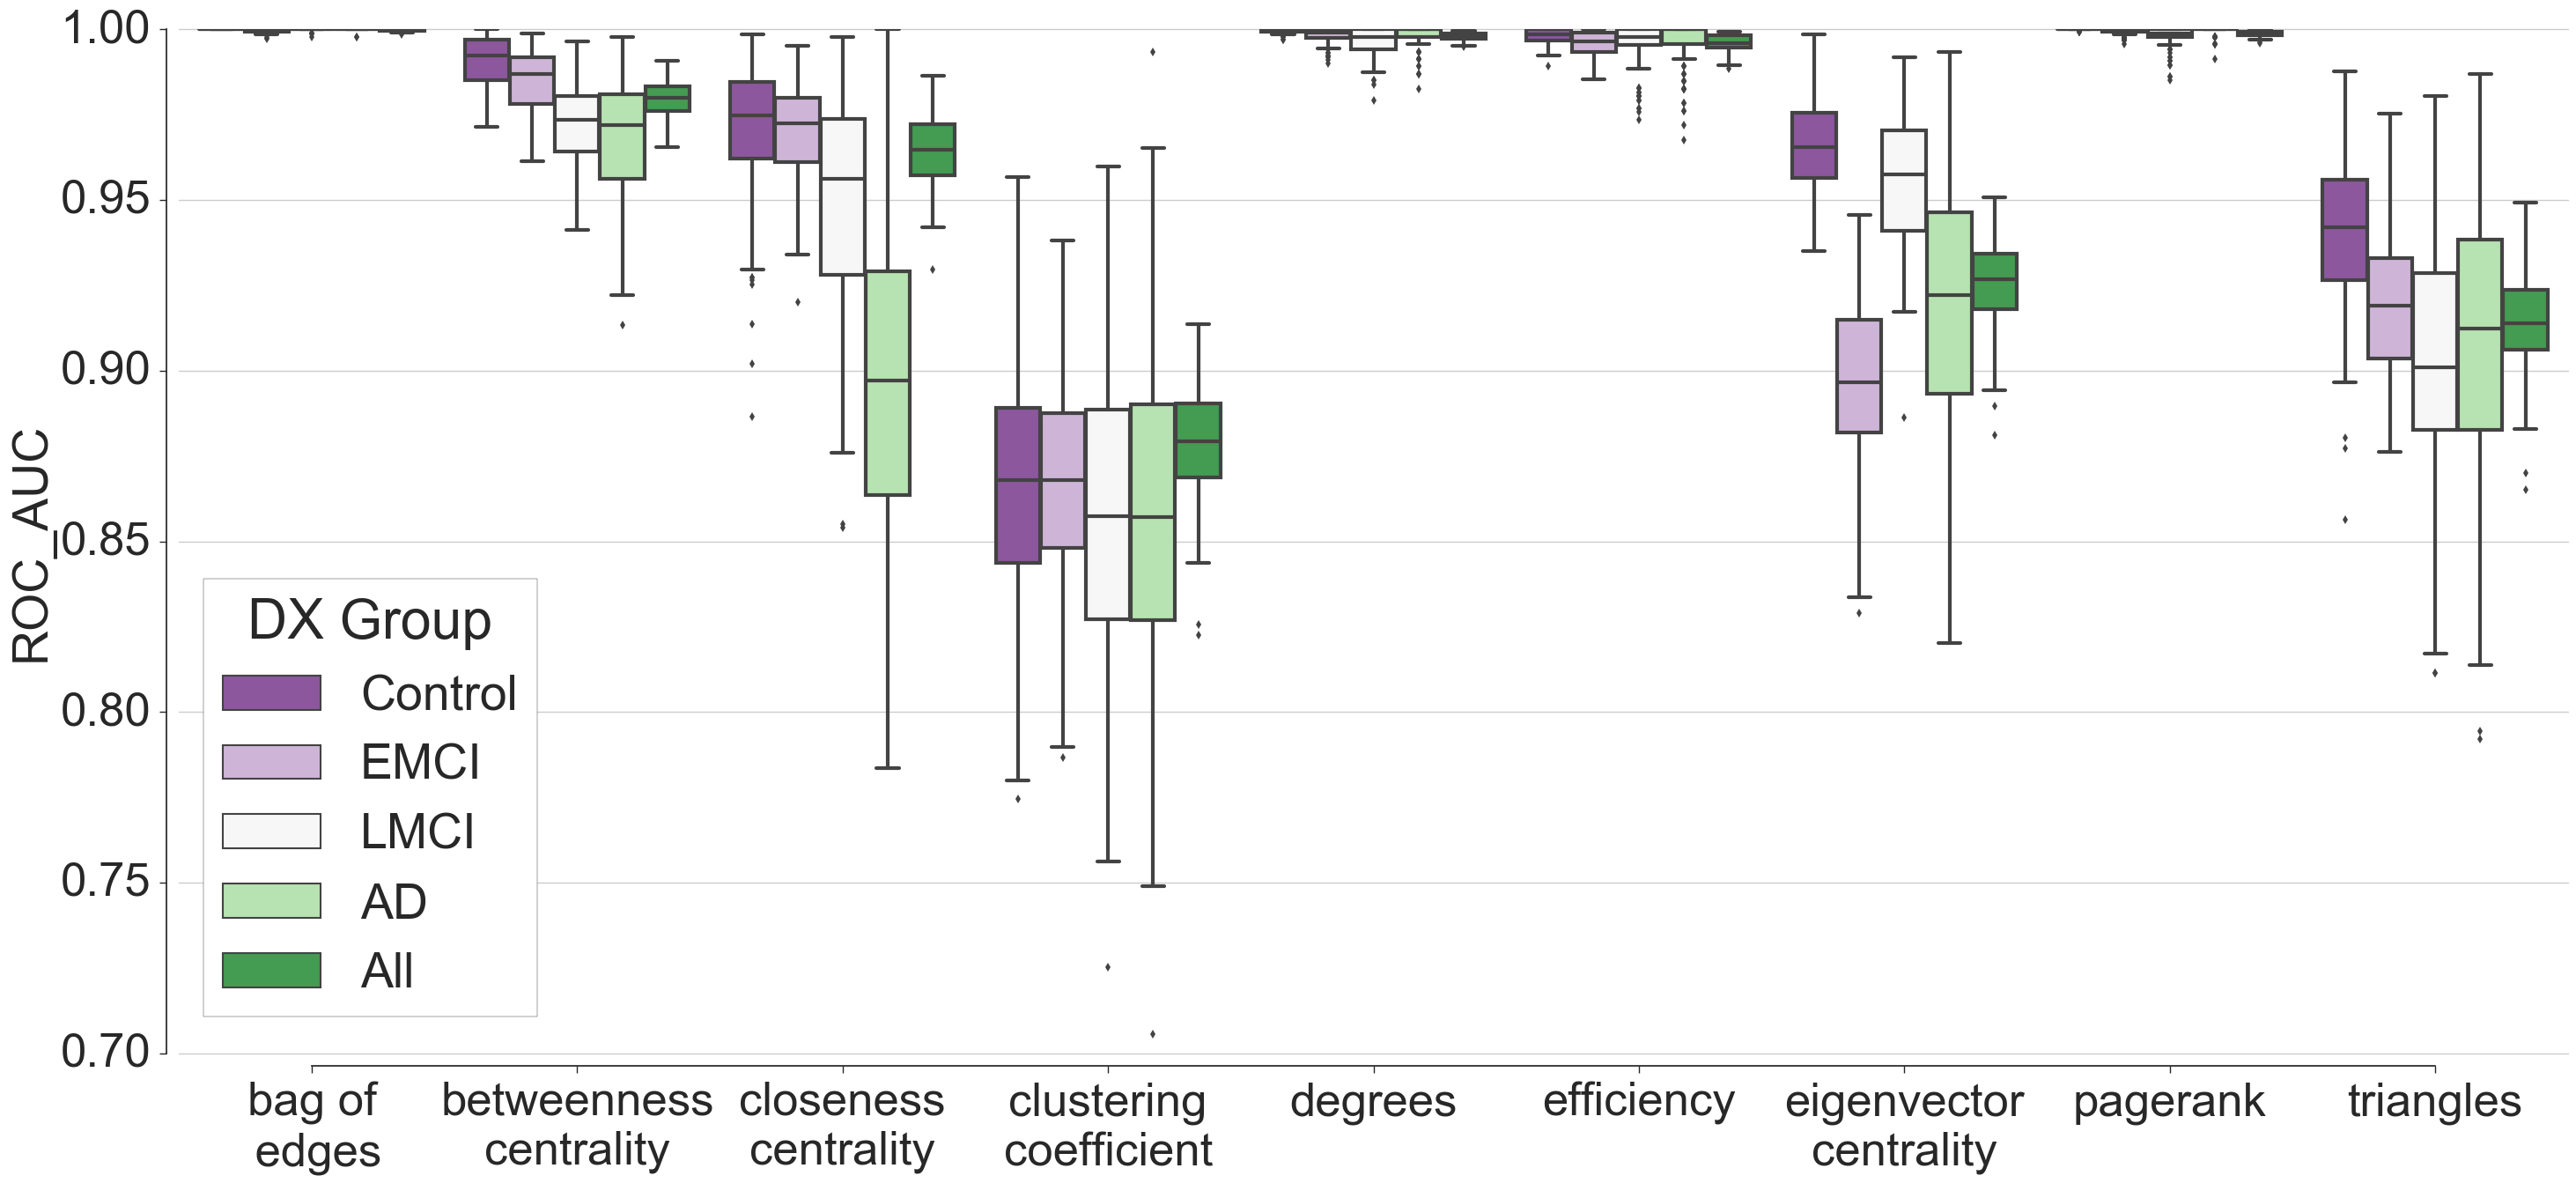

In [33]:
feats = ['data', 'norm', 'base_features', 'eval_accuracy_mean']

#tst = data.sort_values(by = 'eval_accuracy_mean', ascending = False)
target = 'mean'
metric = 'roc_auc'
cur_data = tst.sort_values(by = ['norm', 'data', 'base_features', 'eval_' + metric + '_mean'], ascending = False).copy()
cur_data = cur_data.query('norm == @target')

#target = 'All'
#metric = 'precision'
#cur_data = tst.sort_values(by = ['data', 'norm', 'base_features', 'eval_' + metric + '_mean'], ascending = False).copy()
#cur_data = cur_data.query('data == @target')
#grouped_maxes_ids = cur_data.groupby(by = ['data', 'norm', 'base_features'])['eval_' + metric + '_mean'].idxmax().values

#cur_data['score_list'] = cur_data.loc[grouped_maxes_ids, 'eval_' + metric + '_scores'].apply(get_scores)

#cur_data = cur_data.query('norm == @target & base_features == "betweenness_centrality__param"')
grouped_maxes_ids = cur_data.groupby(by = ['norm', 'data', 'base_features'])['eval_' + metric + '_mean'].idxmax().values
grouped_maxes_ids = np.unique(grouped_maxes_ids)

cur_data['score_list'] = cur_data.loc[grouped_maxes_ids, 'eval_' + metric + '_scores'].apply(get_scores)

row_vals = []
for i, row in cur_data.loc[grouped_maxes_ids].iterrows():
    prefix = list(row[feats])
    cur_scores = row.score_list
    for i in range(100):
        row_vals += [prefix + [cur_scores[i]]]

to_plot = pd.DataFrame(row_vals, columns = feats + ['accuracy'])
#to_plot = to_plot.sort_values(by = 'data', ascending = True)
sns.set(style="ticks")
plt.figure(figsize = (35,15) , dpi = 300)
plot_df = pd.DataFrame(grouped_maxes_ids).reset_index()
# Load the example tips dataset

# Draw a nested boxplot to show bills by day and sex
sns.boxplot(x="base_features", y="accuracy", hue="data", data=to_plot, palette="PRGn",
           saturation = 1.0, width = 0.85, linewidth = 3, order = sorted(to_plot.base_features.unique()), 
        hue_order = ['Control', 'EMCI', 'LMCI', 'AD', 'All'])
sns.despine(offset=10, trim=True)
plt.tick_params(axis='both', which='major', labelsize=38)
plt.tick_params(axis='both', which='minor', labelsize=40)
ax = plt.legend(title = 'DX Group', fontsize = 40, loc='center left', bbox_to_anchor=(0, 0.25), frameon = True)
t = ax.get_title()  #get the text object containing the title
t.set_fontsize(45)  #set the font size
#plt.title('Accuracy for different norms and features for all pairs data', fontsize = 30)
plt.grid(axis = 'y')
plt.xlabel('', fontsize = 40)
plt.ylabel(metric.upper(), fontsize = 40)


plt.savefig('pics/adni_'+ metric +'_boxplots_by_mean_norm_and_targets_without_title.png', transparent=True)


In [40]:
metric[0].upper()

'R'

### PD data

In [41]:
dir_name = 'scripts/PPMI_pairwise_results/'
df_list = []
for item in [item for item in os.listdir(dir_name) if '68' in item]:
    cur_data = pd.read_csv(dir_name + item, index_col = 0)
    cur_data['data'] = item[:-4]
    df_list += [cur_data]
data = pd.concat(df_list, axis=0)
data.index = range(len(data))
data.norm = data.norm.apply(lambda x: x[:-7])
data.base_features = data.base_features.apply(lambda x: x[:-7])

In [42]:
data.data = data.data.apply(lambda x: x[:-3])

In [43]:

forbidden_combinations = [{'norm' : ['-', 'max'], 'base_features' : ['betweenness_centrality']},
                         {'norm' : ['-', 'max'], 'base_features' : ['clustering_coefficient']},
                         {'norm' : ['-', 'max'], 'base_features' : ['eigenvector_centrality']},
                         {'norm' : ['-', 'max'], 'base_features' : ['pagerank']},
                         {'norm' : ['-', 'max'], 'base_features' : ['triangles']}]

all_inds = np.zeros((len(data),))
all_inds = all_inds != 0
for comb in forbidden_combinations:
    comb_keys = sorted(comb.keys())
    inds = np.zeros((len(data),))
    inds = inds == 0
    for key in comb_keys:
        
        loc_inds = data[key].isin(comb[key])
        inds = loc_inds & inds
    all_inds = all_inds | inds    
data = data.loc[~all_inds]

In [44]:
data = data.loc[~all_inds]
def process_centralities(x):
    if 'centrality' in x:
        return x[:-11] + '\n' + 'centrality'
    elif 'clustering' in x:
        return 'clustering' + '\n' + 'coefficient'
    elif x == 'bag_of_edges':
        return 'bag of\n edges'
    else:
        return(x)
data.base_features = data.base_features.apply(process_centralities)

In [45]:
tst = data.sort_values(by = 'eval_accuracy_mean', ascending = False)

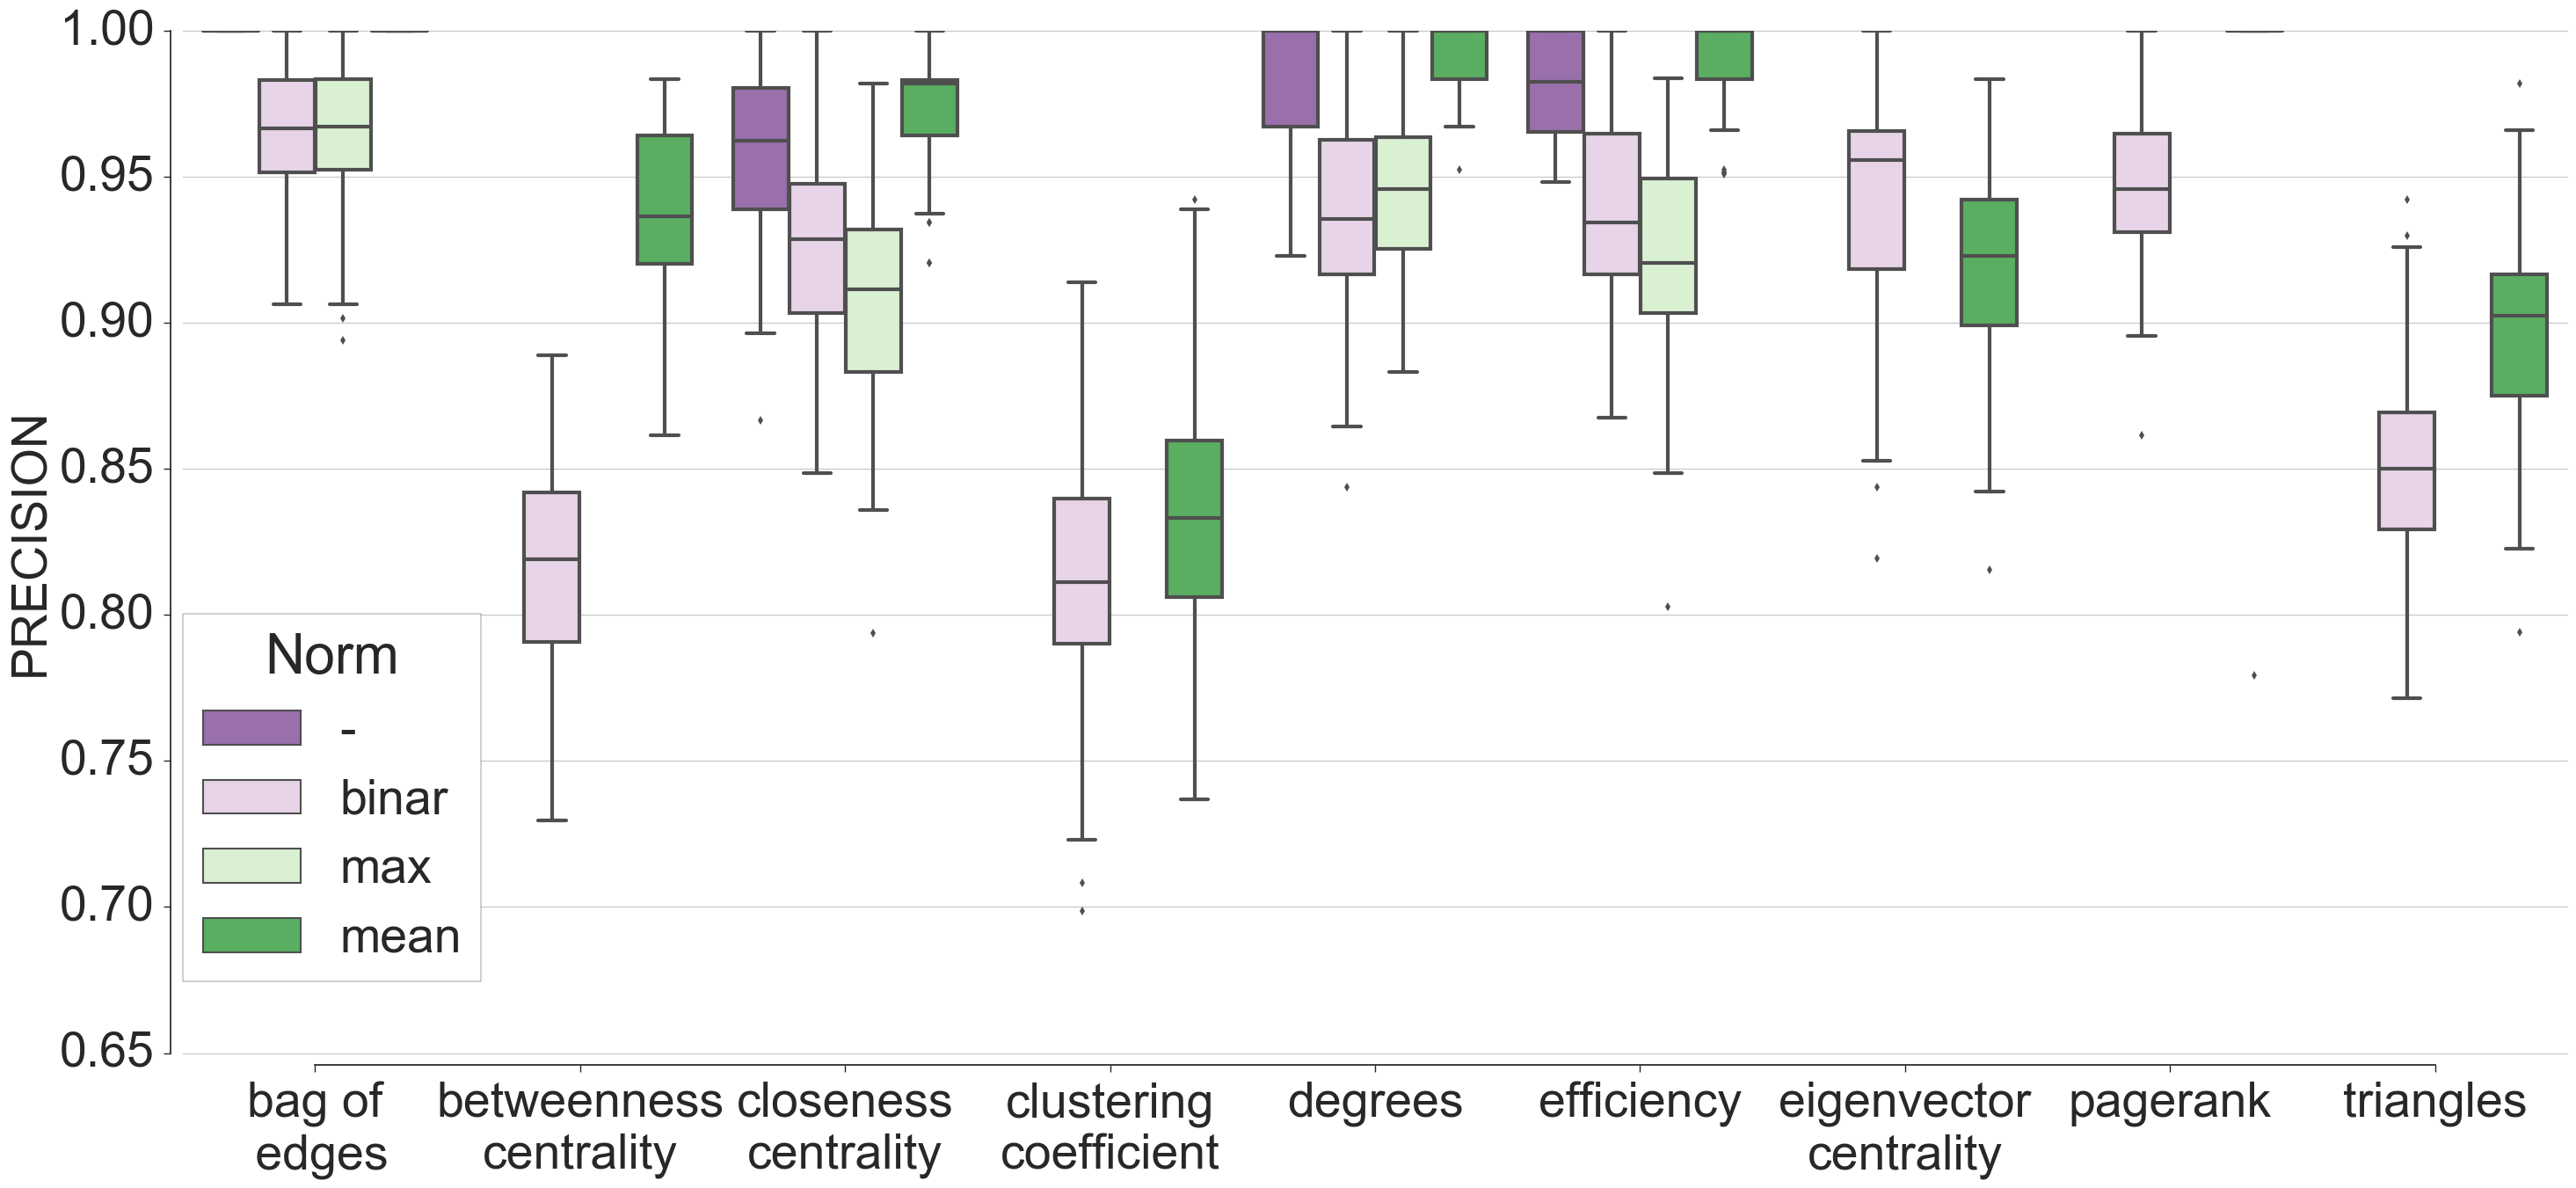

In [48]:
feats = ['data', 'norm', 'base_features', 'eval_accuracy_mean']

target = 'All'
metric = 'precision'
cur_data = tst.sort_values(by = ['data', 'norm', 'base_features', 'eval_' + metric + '_mean'], ascending = False).copy()
cur_data = cur_data.query('data == @target')
grouped_maxes_ids = cur_data.groupby(by = ['data', 'norm', 'base_features'])['eval_' + metric + '_mean'].idxmax().values

cur_data['score_list'] = cur_data.loc[grouped_maxes_ids, 'eval_' + metric + '_scores'].apply(get_scores)

row_vals = []
for i, row in cur_data.loc[grouped_maxes_ids].iterrows():
    prefix = list(row[feats])
    cur_scores = row.score_list
    for i in range(100):
        row_vals += [prefix + [cur_scores[i]]]
to_plot = pd.DataFrame(row_vals, columns = feats + ['accuracy'])
sns.set(style="ticks")
plt.figure(figsize = (35,15) )
plot_df = pd.DataFrame(grouped_maxes_ids).reset_index()
# Load the example tips dataset

# Draw a nested boxplot to show bills by day and sex
sns.boxplot(x="base_features", y="accuracy", hue="norm", data=to_plot, 
            palette="PRGn", saturation = 1.0, width = 0.85, linewidth = 3, 
            order = sorted(to_plot.base_features.unique()))
sns.despine(offset=10, trim=True)
plt.tick_params(axis='both', which='major', labelsize=40)
plt.tick_params(axis='both', which='minor', labelsize=40)
ax = plt.legend(title = 'Norm', fontsize = 40, loc='center left', bbox_to_anchor=(-0.01, 0.25), frameon = True)
t = ax.get_title()  #get the text object containing the title
t.set_fontsize(45)  #set the font size
#plt.title('Accuracy for different norms and features for all pairs data', fontsize = 30)
plt.grid(axis = 'y')
plt.xlabel('', fontsize = 40)
plt.ylabel(metric.upper(), fontsize = 40)


plt.savefig('pics/ppmi_'+metric+'_boxplots_by_norms_and_feats_without_title.png', transparent=True)

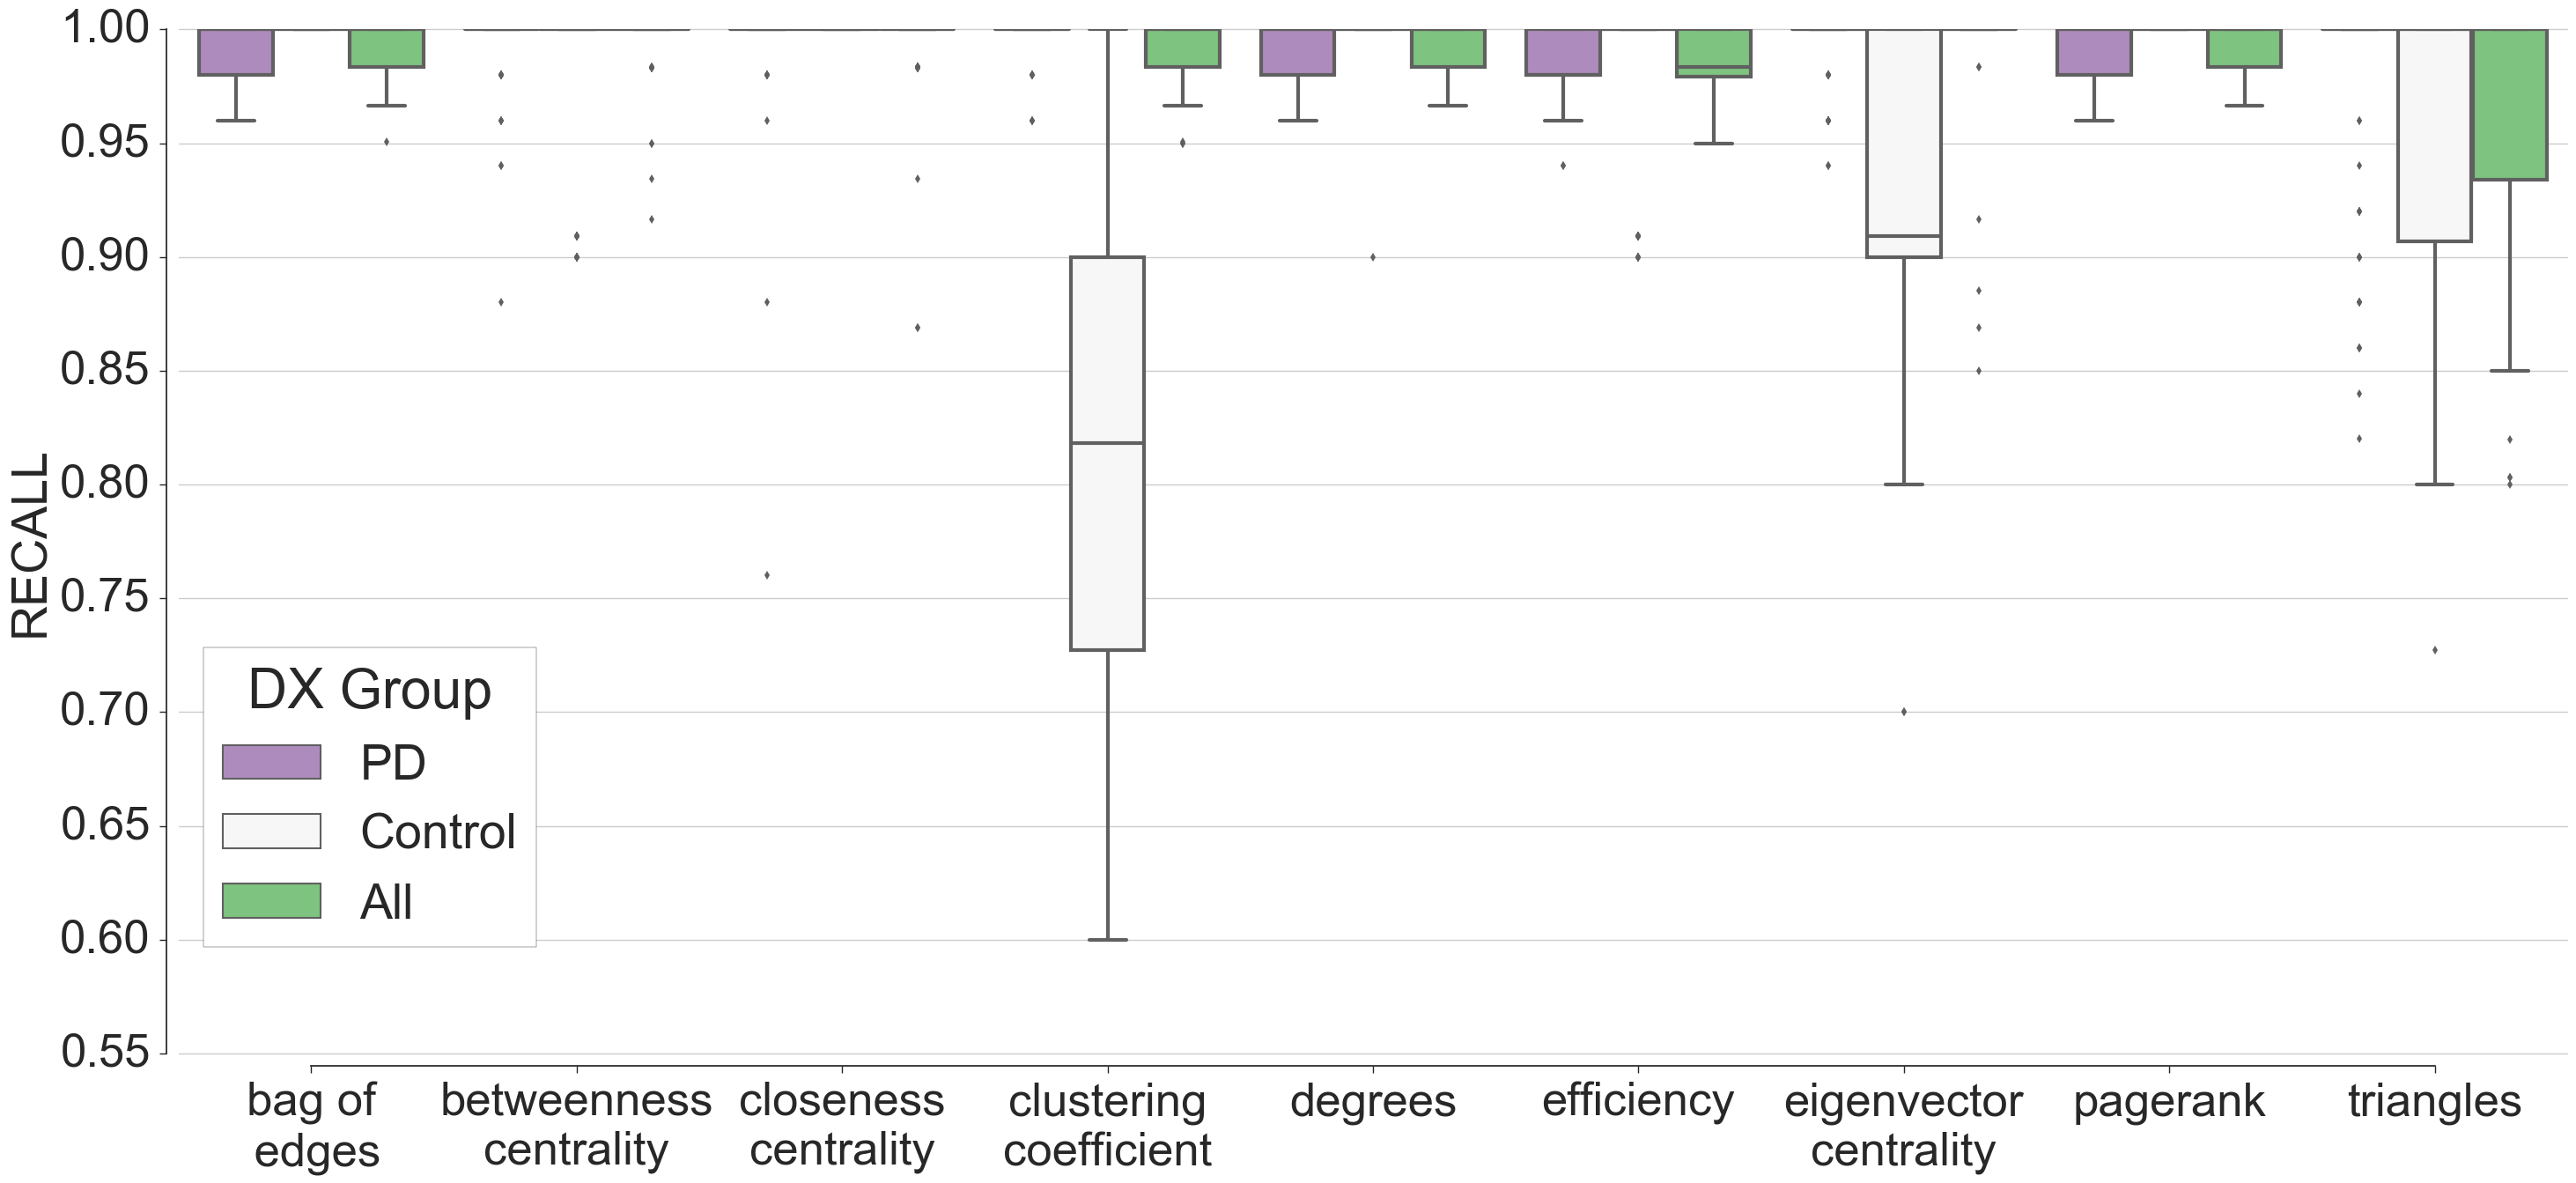

In [51]:
feats = ['data', 'norm', 'base_features', 'eval_accuracy_mean']

#tst = data.sort_values(by = 'eval_accuracy_mean', ascending = False)
target = 'mean'
metric = 'recall'
cur_data = tst.sort_values(by = ['norm', 'data', 'base_features', 'eval_' + metric + '_mean'], ascending = False).copy()
cur_data = cur_data.query('norm == @target')

#target = 'All'
#metric = 'precision'
#cur_data = tst.sort_values(by = ['data', 'norm', 'base_features', 'eval_' + metric + '_mean'], ascending = False).copy()
#cur_data = cur_data.query('data == @target')
#grouped_maxes_ids = cur_data.groupby(by = ['data', 'norm', 'base_features'])['eval_' + metric + '_mean'].idxmax().values

#cur_data['score_list'] = cur_data.loc[grouped_maxes_ids, 'eval_' + metric + '_scores'].apply(get_scores)

#cur_data = cur_data.query('norm == @target & base_features == "betweenness_centrality__param"')
grouped_maxes_ids = cur_data.groupby(by = ['norm', 'data', 'base_features'])['eval_' + metric + '_mean'].idxmax().values
grouped_maxes_ids = np.unique(grouped_maxes_ids)

cur_data['score_list'] = cur_data.loc[grouped_maxes_ids, 'eval_' + metric + '_scores'].apply(get_scores)

row_vals = []
for i, row in cur_data.loc[grouped_maxes_ids].iterrows():
    prefix = list(row[feats])
    cur_scores = row.score_list
    for i in range(100):
        row_vals += [prefix + [cur_scores[i]]]

to_plot = pd.DataFrame(row_vals, columns = feats + ['accuracy'])
#to_plot = to_plot.sort_values(by = 'data', ascending = True)
sns.set(style="ticks")
plt.figure(figsize = (35,15) , dpi = 300)
plot_df = pd.DataFrame(grouped_maxes_ids).reset_index()
# Load the example tips dataset

# Draw a nested boxplot to show bills by day and sex
sns.boxplot(x="base_features", y="accuracy", hue="data", data=to_plot, palette="PRGn",
           saturation = 1.0, width = 0.85, linewidth = 3, order = sorted(to_plot.base_features.unique()), 
        )
sns.despine(offset=10, trim=True)
plt.tick_params(axis='both', which='major', labelsize=38)
plt.tick_params(axis='both', which='minor', labelsize=40)
ax = plt.legend(title = 'DX Group', fontsize = 40, loc='center left', bbox_to_anchor=(0, 0.25), frameon = True)
t = ax.get_title()  #get the text object containing the title
t.set_fontsize(45)  #set the font size
#plt.title('Accuracy for different norms and features for all pairs data', fontsize = 30)
plt.grid(axis = 'y')
plt.xlabel('', fontsize = 40)
plt.ylabel(metric.upper(), fontsize = 40)


plt.savefig('pics/ppmi_'+metric+'_boxplots_by_mean_norm_and_targets_without_title.png', transparent=True)


### Dimensionality reduction

In [22]:
def get_bag_of_edges(file_id, data_dir=data_dir):
    #file_id = row.subject_file
    #print(file_id)
    filename = file_id + '/' + [file for file in os.listdir(data_dir+file_id) if 'FULL' in file][0]
    #print(filename1,filename2)
    matrix = np.loadtxt(data_dir + filename)
    np.fill_diagonal(matrix, 0)
    matrix = matrix/matrix.mean()
    #print(matrix.shape[0])
    inds = np.triu_indices(70, k=1)
    return matrix[inds].reshape(-1)

NameError: name 'data_dir' is not defined